# Predictive Variables

In [1]:
############### CHANGE THESE TO YOUR LIKING ###############

specie = 'leptocybe-invasa' # 'thaumastocoris-peregrinus' # 
region = 'east-asia' # 'australia' # 
training = True
savefig = True

###########################################################

In [2]:
import os

import numpy as np
import xarray as xr
import rioxarray

import pandas as pd
import geopandas as gpd
from geocube.api.core import make_geocube

import matplotlib.pyplot as plt
import matplotlib as mpl

import cartopy.io.shapereader as shapereader


In [3]:
# data_path = os.path.join(os.sep, 'scratch', 'aciar-fst', 'data')
data_path = os.path.join(os.path.dirname(os.getcwd()), 'data')
figs_path = os.path.join(os.path.dirname(os.getcwd()), 'figs')
out_path = os.path.join(os.path.dirname(os.getcwd()), 'out', specie)
input_path = os.path.join(out_path, 'input', 'train') if training else os.path.join(out_path, 'input', 'test')


In [4]:
regions = {
    'east-asia': ['China', 'Taiwan', 'Japan', 'North Korea', 'South Korea'],
    'south-east-asia': ['Brunei', 'Myanmar', 'Cambodia', 'East Timor', 'Indonesia', 'Laos', 'Malaysia', 'Philippines', 'Singapore', 'Thailand', 'Vietnam'],
    'australia': ['Australia'],
    'australasia' : ['Australia', 'New Zealand'],
}

## Load shapefiles of countries

In [5]:
# request data for use by geopandas
resolution = '50m'
category = 'cultural'
name = 'admin_0_countries'

shpfilename = shapereader.natural_earth(resolution, category, name)
countries = gpd.read_file(shpfilename)

In [6]:
# select and combine countries in one dataframe
gdf_countries = gpd.GeoDataFrame()
for country in regions[region]:
    cntry = countries.loc[countries['ADMIN'] == country]
    gdf_countries = pd.concat([gdf_countries, cntry])

In [7]:
shapes = [shape for shape in gdf_countries.geometry]

## 1. Elevation

https://www.ncei.noaa.gov/products/etopo-global-relief-model


In [8]:
# etopo = rioxarray.open_rasterio(os.path.join(data_path, 'topo', 'ETOPO_2022_v1_60s_N90W180_bed.tif'), masked=True)
# etopo_east_asia = etopo.rio.clip(geometries=shapes)
# etopo_east_asia.rio.to_raster(os.path.join('output', 'rasters', 'etopo_east_asia.tif'))

In [9]:
elev_worldclim = os.path.join(data_path, 'worldclim', 'wc2.1_10m_elev.tif')
srtm = rioxarray.open_rasterio(elev_worldclim, masked=True)
srtm_region = srtm.rio.clip(geometries=shapes)
# srtm_east_asia[np.where(srtm_east_asia < 0)].mask = True
srtm_region.name = 'elevation'
srtm_region.rio.to_raster(os.path.join(input_path, 'srtm_%s.tif' %region))

Text(0.5, 1.0, 'Elevation')

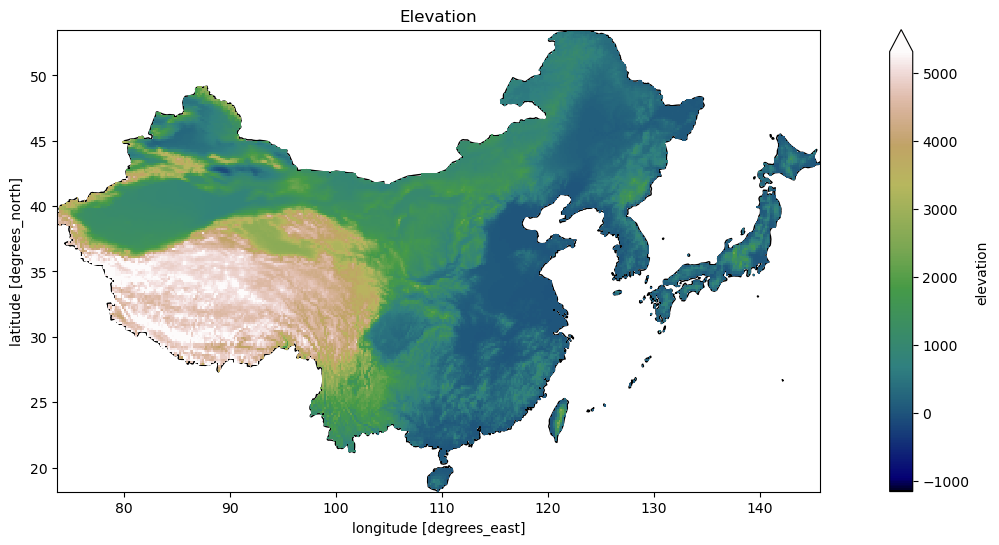

In [10]:
# 0.21875*8000
vmax = 0.85*srtm_region.max()
vmin = np.round((vmax - (1.21875 * vmax)))

fig, ax = plt.subplots(figsize=(18,6))
gdf_countries.plot(ax=ax, facecolor='lightgray', edgecolor='k')
# etopo_east_asia.plot(cmap=plt.cm.terrain, vmin=-2000, vmax=8000)
srtm_region.plot(ax=ax, cmap=plt.cm.gist_earth, vmin=vmin, vmax=vmax)
ax.set_title('Elevation')


In [11]:
if savefig:
    fig.savefig(os.path.join(figs_path, '03_wordclim_topography_%s.png' %region), transparent=True)

## 2. Normalized Difference Vegetation Index (NDVI)
https://land.copernicus.eu/global/products/ndvi

In [12]:
ndvi_nc_file = os.path.join(data_path, 'ndvi', 'c_gls_NDVI-STS_2015-2019-0611_GLOBE_PROBAV_V3.0.1.nc')
ndvi_nc = xr.open_dataset(ndvi_nc_file)

In [13]:
ndvi_nc.rio.write_crs("epsg:4326", inplace=True)
ndvi_nc_region = ndvi_nc.rio.clip(geometries=shapes)

In [14]:
ndvi_median_region = ndvi_nc_region['median']

ndvi_class_bins = [-np.inf, 0, 0.1, 0.25, 0.4, np.inf]
ndvi_class = np.digitize(ndvi_median_region, ndvi_class_bins)

# Apply the nodata mask to the newly classified NDVI data
ndvi_class = np.ma.masked_where(np.isnan(ndvi_median_region), ndvi_class)

ndvi_median_class_region = xr.DataArray(ndvi_class, 
                                        coords={'lat': ndvi_median_region.lat,'lon': ndvi_median_region.lon,'crs': ndvi_median_region.crs}, 
                                        dims=["lat", "lon"])
ndvi_median_class_region.name = 'ndvi_median_classed'
ndvi_median_class_region.rio.to_raster(os.path.join(input_path, 'ndvi-median-classed_%s.tif' %region))

In [15]:
col_dict = {0: ['white', 'Unknown'],
            1: ['gray', 'No Vegetation'],
            2: ['y', 'Bare Area'],
            3: ['yellowgreen', 'Low Vegetation'],
            4: ['g', 'Moderate Vegetation'],
            5: ['darkgreen', 'High Vegetation']}

cmap = mpl.colors.ListedColormap([col_dict[x][0] for x in col_dict.keys()])
labels = [col_dict[x][1] for x in col_dict.keys()]
cmap.set_bad='k'

norm = mpl.colors.BoundaryNorm(np.arange(-0.5,6), cmap.N) 
fmt = mpl.ticker.FuncFormatter(lambda x, pos: labels[norm(x)])

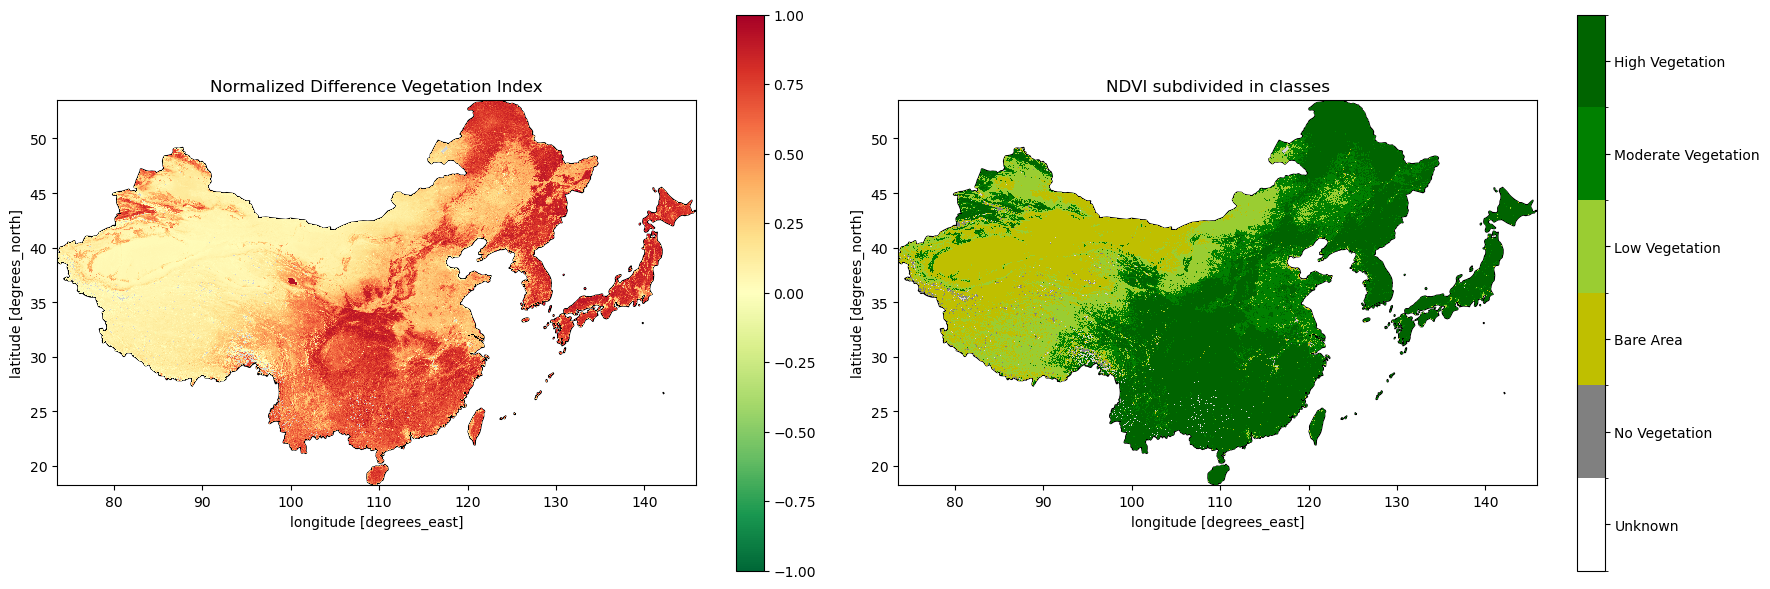

In [16]:
fig, ax = plt.subplots(ncols=2, figsize=(18, 6))

gdf_countries.plot(ax=ax[0], facecolor='lightgray', edgecolor='k')
pcol = ndvi_median_region.plot(ax=ax[0], cmap=plt.cm.RdYlGn_r, vmin=-1, vmax=1, add_colorbar=False)
plt.colorbar(pcol)
ax[0].set_title('Normalized Difference Vegetation Index')

gdf_countries.plot(ax=ax[1], facecolor='lightgray', edgecolor='k')
pcol = ndvi_median_class_region.plot(ax=ax[1], cmap=cmap, norm=norm, add_colorbar=False)
plt.colorbar(pcol, format=fmt, ticks=np.linspace(0,5,6))
ax[1].set_title('NDVI subdivided in classes')

# Auto adjust subplot to fit figure size
plt.tight_layout()

In [17]:
if savefig:
    fig.savefig(os.path.join(figs_path, '03_ndvi_%s.png' %region), transparent=True)

## 3. WorldClim

In [18]:
bioclim_names = {
    1: 'Annual Mean Temperature',
    2: 'Mean Diurnal Range (Mean of monthly (max temp - min temp))',
    3: 'Isothermality (BIO2/BIO7) (×100)',
    4: 'Temperature Seasonality (standard deviation ×100)',
    5: 'Max Temperature of Warmest Month',
    6: 'Min Temperature of Coldest Month',
    7: 'Temperature Annual Range (BIO5-BIO6)',
    8: 'Mean Temperature of Wettest Quarter',
    9: 'Mean Temperature of Driest Quarter',
    10: 'Mean Temperature of Warmest Quarter',
    11: 'Mean Temperature of Coldest Quarter',
    12: 'Annual Precipitation',
    13: 'Precipitation of Wettest Month',
    14: 'Precipitation of Driest Month',
    15: 'Precipitation Seasonality (Coefficient of Variation)',
    16: 'Precipitation of Wettest Quarter',
    17: 'Precipitation of Driest Quarter',
    18: 'Precipitation of Warmest Quarter',
    19: 'Precipitation of Coldest Quarter'
}

In [19]:
bioclim_no = list(np.arange(1,20))#[1, 5, 6, 12, 13, 14]
file_names_worldclim = []
for no in bioclim_no:
    file_names_worldclim.append('wc2.1_10m_bio_%s.tif' %no) 

In [20]:
rasters, labels = [], []
for no, file_name in zip(bioclim_no, file_names_worldclim):

    worldclim = rioxarray.open_rasterio(os.path.join(data_path, 'worldclim', file_name), masked=True)
    wc_region = worldclim.rio.clip(geometries=shapes)
    wc_region.name = bioclim_names[no]
    wc_region.rio.to_raster(os.path.join(input_path, 'wc2.1_10m_bio_%s_%s.tif' %(no, region))) #'wc2.1_10m_bio-%02d_%s.tif'
    
    rasters.append('wc2.1_10m_bio_%s_%s.tif' %(no, region))
    labels.append('bioclim-%02d' %no)

titles = ['bio-%02d: %s' %(no, name) for (no, name) in bioclim_names.items()]
# rasters, labels, titles

In [21]:
# bioclim_plot = input('Provide bioclim numbers to plot (max of 9):').split()
# bioclim_plot = [int(bc) for bc in bioclim_plot]

In [22]:
bioclim_plot = [1, 5, 6, 12, 13, 14]

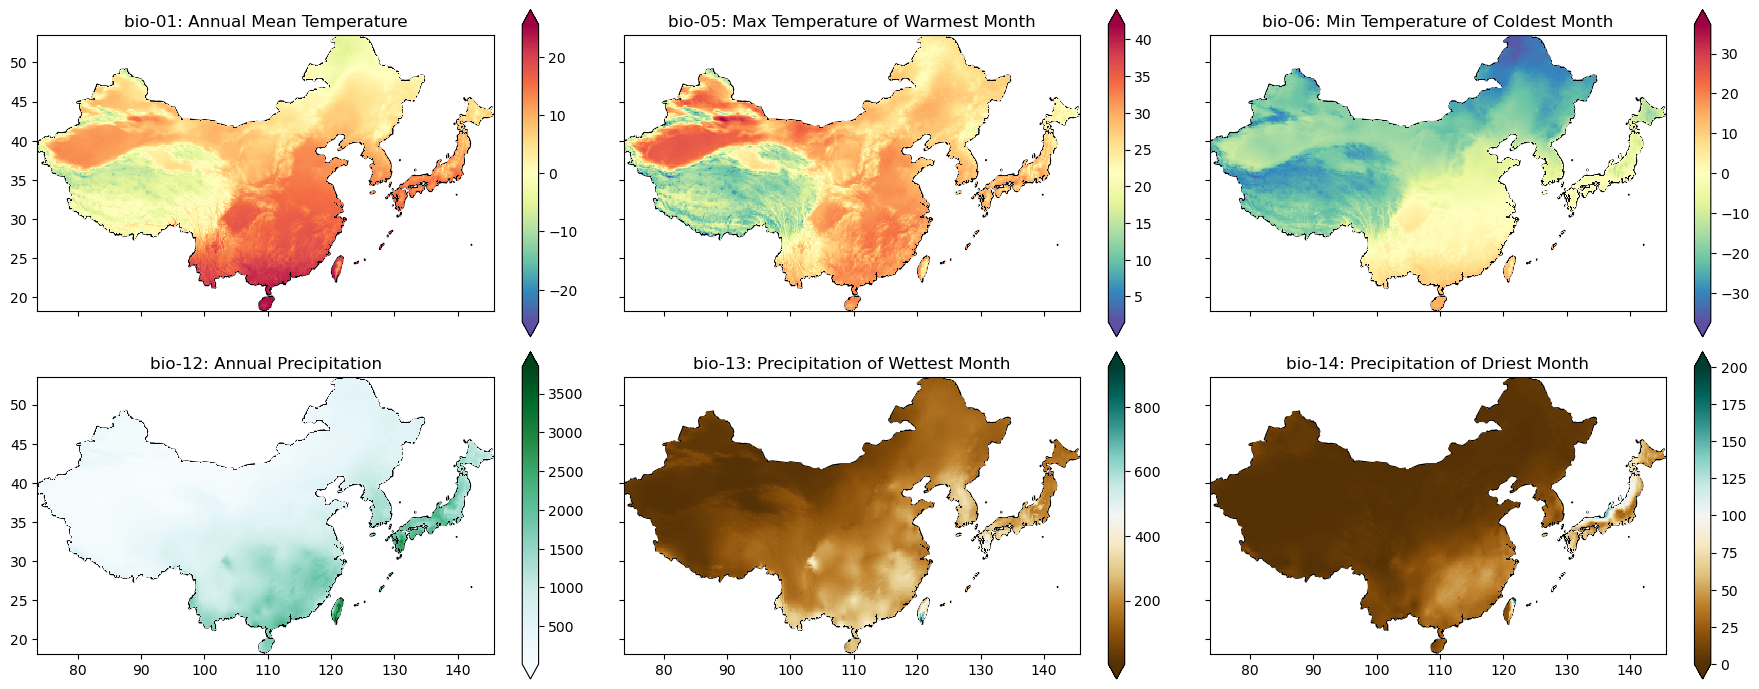

In [23]:
# attrs = {
#     titles[0]: [plt.cm.Spectral_r, -25, 35],
#     titles[1]: [plt.cm.Spectral_r, -25, 35],
#     titles[2]: [plt.cm.Spectral_r, -25, 35],
#     titles[3]: [plt.cm.BuGn, 0, 2000],
#     titles[4]: [plt.cm.BrBG, 0, 400],
#     titles[5]: [plt.cm.BrBG, 0, 100]}

if len(bioclim_plot) <= 3:
    nrows, ncols = 1, len(bioclim_plot)
    figsize = (18, 4)
elif 3 < len(bioclim_plot) <= 6:
    nrows, ncols = 2, 3
    figsize = (18, 7)
elif 6 < len(bioclim_plot) <= 9:
    nrows, ncols = 3, 3
    figsize = (18, 10)


fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, sharex=True, sharey=True)
for iax, bc_no in enumerate(bioclim_plot):
    r, c = iax // ncols, iax % ncols
    axes = ax[c] if nrows == 1 else ax[r, c]
    ds = rioxarray.open_rasterio(os.path.join(input_path, rasters[bc_no - 1]), masked=True)
    if bc_no < 12:
        cmap = plt.cm.Spectral_r
    elif bc_no == 12:
        cmap = plt.cm.BuGn
    else:
        cmap = plt.cm.BrBG
    gdf_countries.plot(ax=axes, facecolor='lightgray', edgecolor='k')
#     pcol = ds.plot(ax=ax[r, c], cmap=attrs[titles[iax]][0], vmin=attrs[titles[iax]][1], vmax=attrs[titles[iax]][2], add_colorbar=False, add_labels=False)
    pcol = ds.plot(ax=axes, cmap=cmap, add_colorbar=False, add_labels=False)
    axes.set_title(titles[bc_no - 1])
    
    plt.colorbar(pcol, extend='both')

plt.tight_layout()

In [24]:
if savefig:
    fig.savefig(os.path.join(figs_path, '03_wordclim_bioclim_%s.png' %region), transparent=True)

In [22]:
# Percent Tree Cover (PTC)